<div align="center">

### **EXAM #2 SIGNALS AND SYSTEMS - 2025 2S**
#### **Student:** Martín Ramírez Espinosa
##### Department of Electrical, Electronic and Computer Engineering
##### National University of Colombia - Manizales Campus

</div>

---

In [1]:
import numpy as np
import shutil
from pathlib import Path
from typing import Tuple, Optional
from yt_dlp import YoutubeDL
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from IPython.display import Audio, display

---

**1.** Consider the AM demodulator shown in the following figure:

<p align="center"><img src="demodulation-system.png" alt="AM demodulation diagram" style="max-width:100%; width:85%;"></p>

Assuming $\theta_0 = 0$, analytically derive the theoretical Fourier spectrum at each stage of the scheme. Then, take 5 seconds of a YouTube song as the message signal $m(t)$ and plot in the time and frequency domains the main stages of the modulation and demodulation process, playing the associated audio in each case. For the low-pass stage, implement an ideal filter in the frequency domain using the FFT.

In [ ]:
def clear_cache(
        cache_dir: Optional[str] = None  # Path to cache directory
) -> None:                               # No return value
    ''' Clears the cache directory '''
    # Determine cache path (default: ./cache)
    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "cache"
    if not cache_path.exists() or not cache_path.is_dir():
        return # Nothing to clear

    # Remove all files and directories in cache, except .gitignore
    for entry in cache_path.iterdir():
        if entry.name == ".gitignore":
            continue
        if entry.is_dir():
            shutil.rmtree(entry)
        else:
            entry.unlink()


def get_audio(
    url: str,                         # YouTube video URL
    start_s: float = 0.0,             # Start time of audio segment [s]
    duration_s: float = 5.0,          # Duration of audio segment [s]
    sample_rate_hz: int = 44100,      # Desired sample rate [Hz]
    cache_dir: Optional[str] = None,  # Path to cache directory
    clean_cache: bool = True,         # Whether to clear cache before downloading
) -> Tuple[np.ndarray, int]:          # (audio samples, sample rate)
    ''' Downloads audio from a YouTube URL and returns a segment as a numpy array '''
    # Setup cache directory
    cache_path = Path(cache_dir) if cache_dir else Path.cwd() / "cache"
    if clean_cache:
        clear_cache(cache_path)
    cache_path.mkdir(parents=True, exist_ok=True)

    # Download audio using yt-dlp
    ydl_opts = {
        "format": "bestaudio/best",                     # Best audio format
        "outtmpl": str(cache_path / "%(id)s.%(ext)s"),  # Output template
        "quiet": True,                                  # Suppress output
        "no_warnings": True,                            # Suppress warnings
    }

    # Download audio file
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)              # Extract info and download
        audio_file = cache_path / f"{info['id']}.{info['ext']}"  # Path to downloaded audio file

    # Load audio segment using pydub
    segment = AudioSegment.from_file(audio_file)                                       # Load audio file
    start_ms = max(int(start_s * 1000), 0)                                             # Start time in milliseconds
    end_ms = start_ms + int(duration_s * 1000)                                         # End time in milliseconds
    segment = segment[start_ms:end_ms].set_channels(1).set_frame_rate(sample_rate_hz)  # Mono and desired sample rate

    # Convert audio segment to numpy array
    raw = np.asarray(segment.get_array_of_samples())            # Raw audio samples
    samples = raw.astype(np.float32) / np.iinfo(raw.dtype).max  # Normalize to [-1, 1]
    return samples, sample_rate_hz

In [3]:
link = "https://www.youtube.com/watch?v=DraDpi4bM-Y"

In [4]:
msg_t, f_s = get_audio(link, start_s = 15.0)

In [ ]:
def plot_domains(
        msg_t: np.ndarray,  # Time-domain message signal
        f_s: int            # Sampling frequency [Hz]
) -> None:                  # No return value
    ''' Plots the time and frequency domains of the message signal and plays the audio '''
    # Time domain
    N = len(msg_t)                                  # Number of samples
    T_s = 1.0 / f_s                                 # Sampling period [s]
    t = np.linspace(0.0, N*T_s, N, endpoint=False)  # Time vector
    
    # Frequency domain
    msg_f = fft(msg_t)          # Frequency-domain message signal
    f = fftfreq(N, T_s)[:N//2]  # Frequency vector

    plt.figure(figsize=(12, 6))
    # Time Domain Plot
    plt.subplot(2, 1, 1)
    plt.plot(t, msg_t, color='blue')
    plt.title("Time Domain")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    # Frequency Domain Plot
    plt.subplot(2, 1, 2)
    plt.plot(f, 2.0/N * np.abs(msg_f[0:N//2]), color='red')
    plt.title("Frequency Domain")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")

    plt.tight_layout()
    plt.show()
    # Play audio
    display(Audio(msg_t, rate=f_s))

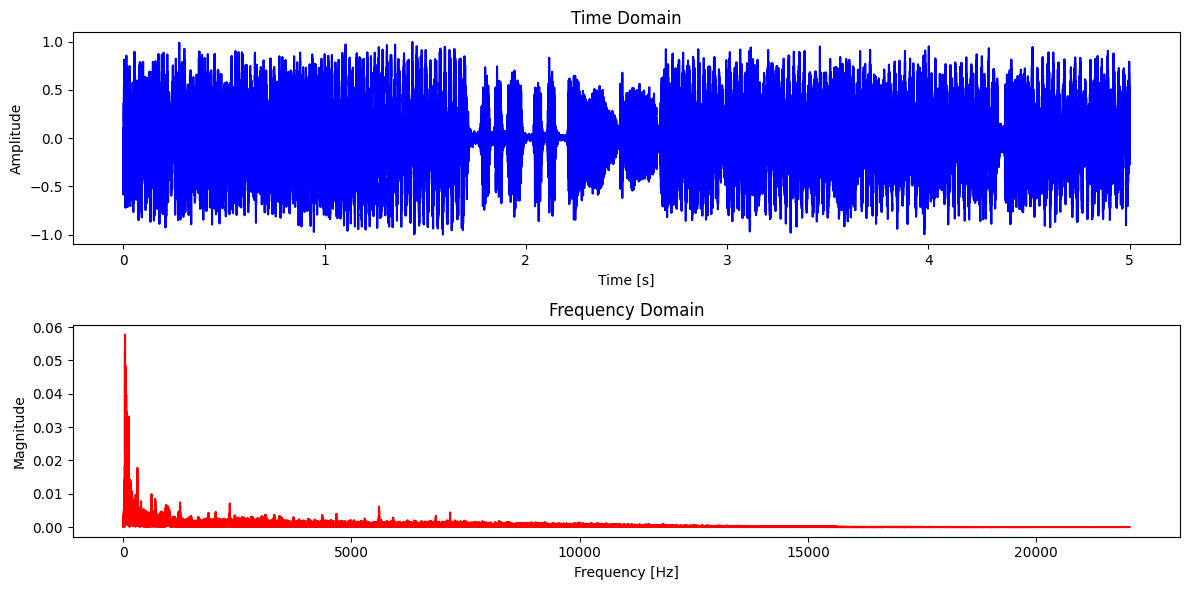

In [6]:
plot_domains(msg_t, f_s)

---

In [ ]:
def am_modulate(
        msg_t: np.ndarray,             # Time-domain message signal
        f_s: int,                      # Sampling frequency [Hz]
        carrier_hz: float = 10000.0,   # Carrier frequency [Hz]
        modulation_index: float = 1.0  # Modulation index (depth)
) -> np.ndarray:                       # AM modulated signal
    """Perform DSB-SC (carrier-suppressed) modulation on the message signal."""
    # Validate modulation index
    if modulation_index < 0:
        raise ValueError("modulation_index must be non-negative")
    
    # Normalize message signal
    message = np.asarray(msg_t, dtype=float)
    peak = np.max(np.abs(message))
    if peak == 0:
        return np.zeros_like(message)  # Avoid division by zero

    normalized_msg = message / peak
    t = np.arange(len(message)) / f_s
    # Carrier signal
    carrier = np.cos(2 * np.pi * carrier_hz * t)
    return modulation_index * normalized_msg * carrier

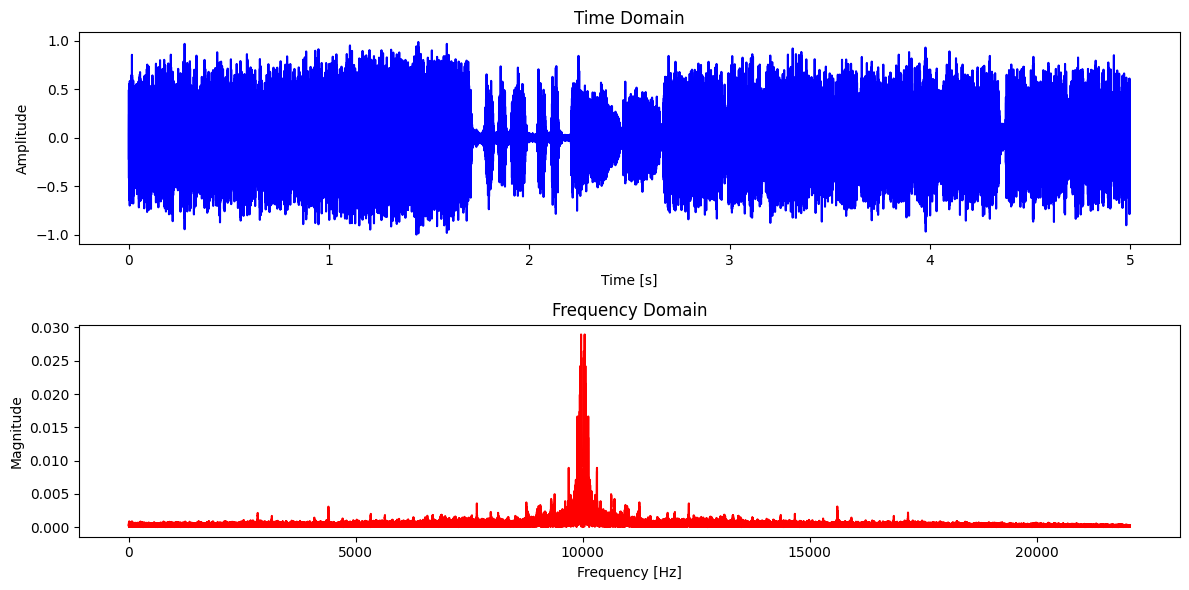

In [8]:
am_t = am_modulate(msg_t, f_s)
plot_domains(am_t, f_s)

In [ ]:
def ideal_lowpass_fft(
        signal: np.ndarray,  # Input signal
        f_s: int,            # Sampling frequency [Hz]
        cutoff_hz: float     # Cutoff frequency [Hz]
) -> np.ndarray:             # Filtered signal
    """Ideal low-pass filter via FFT magnitude masking."""
    freqs = np.fft.fftfreq(len(signal), d=1.0 / f_s)
    spectrum = np.fft.fft(signal)
    # Create ideal low-pass filter mask
    mask = np.abs(freqs) <= cutoff_hz
    return np.fft.ifft(spectrum * mask).real


def am_demodulate(
        am_t: np.ndarray,               # AM modulated signal
        f_s: int,                       # Sampling frequency [Hz]
        carrier_hz: float = 10000.0,    # Carrier frequency [Hz]
        cutoff_hz: float | None = None  # Cutoff frequency for LPF [Hz]
) -> np.ndarray:                        # Demodulated message signal
    """Demodulate a DSB-SC AM signal using coherent detection and ideal LPF."""
    if cutoff_hz is None:
        cutoff_hz = 0.45 * (f_s / 2.0)  # Default cutoff frequency [Hz]

    t = np.arange(len(am_t)) / f_s
    # Coherent detection (mixing with carrier)
    mixed = 2 * am_t * np.cos(2 * np.pi * carrier_hz * t)
    return ideal_lowpass_fft(mixed, f_s, cutoff_hz)

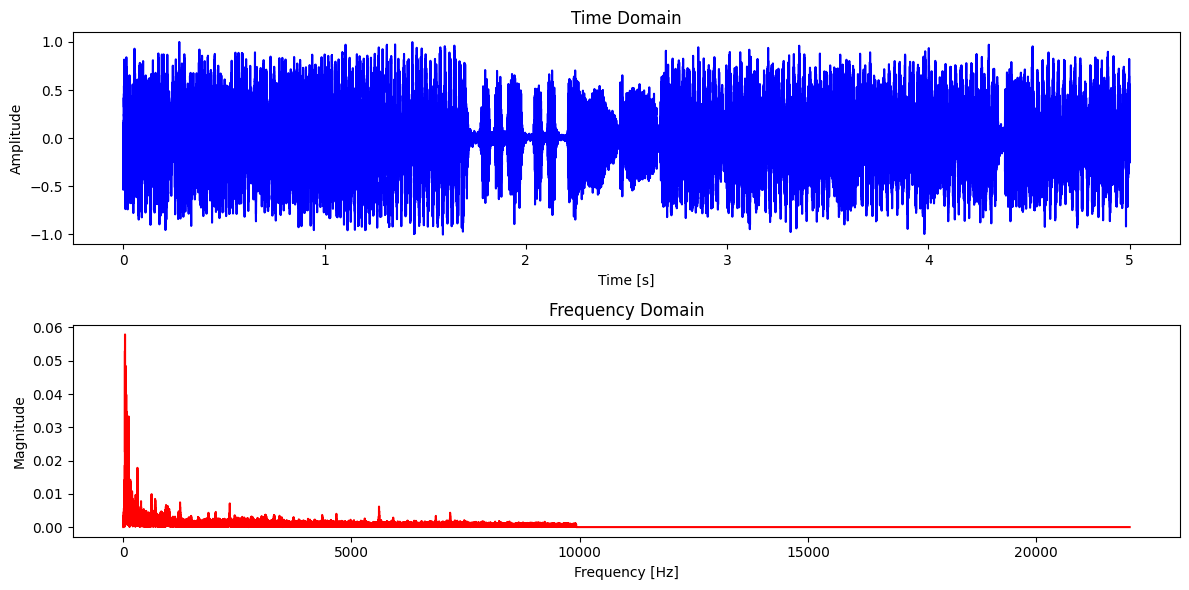

In [10]:
demod_t = am_demodulate(am_t, f_s)
plot_domains(demod_t, f_s)

---

**2.** Determine the transfer function that models the mass-spring-damper system shown in the following figure:

<p align="center"><img src="spring-mass-damper.png" alt="Mass-spring-damper system" style="max-width:70%; width:38%;"></p>

Next, obtain the equivalent model from the electrical circuit shown:

<p align="center"><img src="rlc-system.png" alt="Equivalent RLC circuit" style="max-width:80%; width:55%;"></p>

Propose numerical values for $m, k,$ and $c$ and their equivalents $R, L,$ and $C$ that allow you to simulate underdamped, overdamped, and critically damped regimes; for each case compute the damping ratio, the damped natural frequency, the undamped natural frequency, the peak time, the rise time, and the settling time. For each scenario, plot the pole-zero map, the Bode diagram, the impulse response, the step response, and the ramp response. Repeat the procedure for the closed-loop system.

---

**Mass-spring-damper to RLC mapping and test cases**

The mass-spring-damper obeys $m\ddot{x}+c\dot{x}+kx=F$, so $\displaystyle \frac{X(s)}{F(s)}=\frac{1}{ms^2+cs+k}$. Using the force-voltage analogy, the equivalent series RLC circuit gives $\displaystyle \frac{Q(s)}{V(s)}=\frac{1}{Ls^2+Rs+1/C}$ with $L=m$, $R=c$, and $C=1/k$.

Three parameter sets are used to cover the required regimes (unity-feedback is used for the closed loop):
- Underdamped: $m=1$ kg, $c=10$ N·s/m, $k=100$ N/m ($R=10$ $\Omega$, $L=1$ H, $C=0.01$ F, $\zeta=0.5$).
- Critically damped: $m=1$ kg, $c=20$ N·s/m, $k=100$ N/m ($R=20$ $\Omega$, $L=1$ H, $C=0.01$ F, $\zeta=1$).
- Overdamped: $m=1$ kg, $c=40$ N·s/m, $k=100$ N/m ($R=40$ $\Omega$, $L=1$ H, $C=0.01$ F, $\zeta=2$).


In [ ]:
import numpy as np
import pandas as pd
import sympy as sp
import sympy.physics.control as ctrl

s = sp.symbols('s', complex=True)

def mechanical_tf(m: float, c: float, k: float) -> ctrl.TransferFunction:
    return ctrl.TransferFunction(1, sp.expand(m*s**2 + c*s + k), s)

def electrical_equivalent(m: float, c: float, k: float) -> dict:
    return {"R": float(c), "L": float(m), "C": float(1.0 / k)}

def denominator_coeffs(tf: ctrl.TransferFunction) -> tuple[float, float, float]:
    den_poly = sp.Poly(sp.expand(tf.den), tf.var)
    coeffs = [float(sp.N(c)) for c in den_poly.all_coeffs()]
    if len(coeffs) != 3:
        raise ValueError("The model is not second order.")
    return coeffs[0], coeffs[1], coeffs[2]

def natural_quantities(a0: float, a1: float, a2: float) -> tuple[float, float, float]:
    wn = float(np.sqrt(a2 / a0))
    zeta = float(a1 / (2 * np.sqrt(a0 * a2)))
    if abs(zeta - 1.0) < 1e-10:
        wd = 0.0
    elif zeta < 1.0:
        wd = float(wn * np.sqrt(1.0 - zeta**2))
    else:
        wd = float('nan')
    return wn, zeta, wd

def closed_loop_unity(tf: ctrl.TransferFunction) -> ctrl.TransferFunction:
    return ctrl.TransferFunction(tf.num, sp.simplify(tf.den + tf.num), tf.var)

def choose_time_window(wn: float, zeta: float) -> float:
    base = max(8.0 / max(wn, 1e-6), 0.4)
    if zeta < 0.4:
        base *= 2.0
    elif zeta > 1.2:
        base *= 0.8
    return float(base)

def step_time_metrics(tf: ctrl.TransferFunction, horizon: float, target: float | None = None) -> tuple[float, float, float, float]:
    t, y = ctrl.step_response_numerical_data(tf, upper_limit=horizon, adaptive=False, n=600)
    t_arr = np.asarray(t, dtype=float)
    y_arr = np.asarray(y, dtype=float)
    final_val = float(target if target is not None else y_arr[-1])
    # Rise time (10-90%)
    rise_time = float('nan')
    idx10 = np.where(y_arr >= 0.1 * final_val)[0]
    idx90 = np.where(y_arr >= 0.9 * final_val)[0]
    if idx10.size and idx90.size:
        rise_time = float(t_arr[idx90[0]] - t_arr[idx10[0]])
    peak_idx = int(np.argmax(y_arr))
    peak_time = float(t_arr[peak_idx])
    band = 0.02 * max(abs(final_val), 1e-6)
    settling_time = float('nan')
    for i in range(len(y_arr)):
        if np.all(np.abs(y_arr[i:] - final_val) <= band):
            settling_time = float(t_arr[i])
            break
    return rise_time, peak_time, settling_time, final_val

def collect_metrics(label: str, tf: ctrl.TransferFunction, loop_label: str, m: float, c: float, k: float, equivalents: dict):
    a0, a1, a2 = denominator_coeffs(tf)
    wn, zeta, wd = natural_quantities(a0, a1, a2)
    time_window = choose_time_window(wn, zeta)
    dc_gain = float(sp.N(tf.num.subs(tf.var, 0) / tf.den.subs(tf.var, 0)))
    rise_time, peak_time, settling_time, final_val = step_time_metrics(tf, time_window, target=dc_gain)
    metrics = {
        "Scenario": label,
        "Loop": loop_label,
        "m": m,
        "c": c,
        "k": k,
        "den_a0": a0,
        "den_a1": a1,
        "den_a2": a2,
        "zeta": zeta,
        "wn_rad_s": wn,
        "wd_rad_s": wd,
        "peak_time_s": peak_time,
        "rise_time_s": rise_time,
        "settling_time_s": settling_time,
        "dc_gain": dc_gain,
        "R": equivalents["R"],
        "L": equivalents["L"],
        "C": equivalents["C"]
    }
    return metrics, time_window


In [12]:
cases = {
    "Underdamped": {"m": 1.0, "c": 10.0, "k": 100.0},
    "Critically damped": {"m": 1.0, "c": 20.0, "k": 100.0},
    "Overdamped": {"m": 1.0, "c": 40.0, "k": 100.0}
}

results = []
plot_windows: dict[tuple[str, str], float] = {}

for label, params in cases.items():
    base_tf = mechanical_tf(**params)
    eq_vals = electrical_equivalent(**params)
    open_metrics, open_tw = collect_metrics(label, base_tf, "open-loop", equivalents=eq_vals, **params)
    results.append(open_metrics)
    plot_windows[(label, "open-loop")] = open_tw

    closed_tf = closed_loop_unity(base_tf)
    closed_metrics, closed_tw = collect_metrics(label, closed_tf, "closed-loop", equivalents=eq_vals, **params)
    results.append(closed_metrics)
    plot_windows[(label, "closed-loop")] = closed_tw

summary_df = pd.DataFrame(results)
display(summary_df[["Scenario", "Loop", "zeta", "wn_rad_s", "wd_rad_s", "peak_time_s", "rise_time_s", "settling_time_s", "dc_gain", "den_a0", "den_a1", "den_a2", "R", "L", "C"]].round(4))


,Scenario,Loop,zeta,wn_rad_s,wd_rad_s,peak_time_s,rise_time_s,settling_time_s,dc_gain,den_a0,den_a1,den_a2,R,L,C
0,Underdamped,open-loop,0.5000,10.0000,8.6603,0.3633,0.1643,NaN,0.0100,1.0,10.0,100.0,10.0,1.0,0.01
1,Underdamped,closed-loop,0.4975,10.0499,8.7178,0.3601,0.1621,NaN,0.0099,1.0,10.0,101.0,10.0,1.0,0.01
2,Critically damped,open-loop,1.0000,10.0000,0.0000,0.8000,0.3366,0.5836,0.0100,1.0,20.0,100.0,20.0,1.0,0.01
3,Critically damped,closed-loop,0.9950,10.0499,1.0000,0.7960,0.3322,0.5754,0.0099,1.0,20.0,101.0,20.0,1.0,0.01
4,Overdamped,open-loop,2.0000,10.0000,NaN,0.6400,NaN,NaN,0.0100,1.0,40.0,100.0,40.0,1.0,0.01
5,Overdamped,closed-loop,1.9901,10.0499,NaN,0.6368,NaN,NaN,0.0099,1.0,40.0,101.0,40.0,1.0,0.01


Underdamped – open-loop


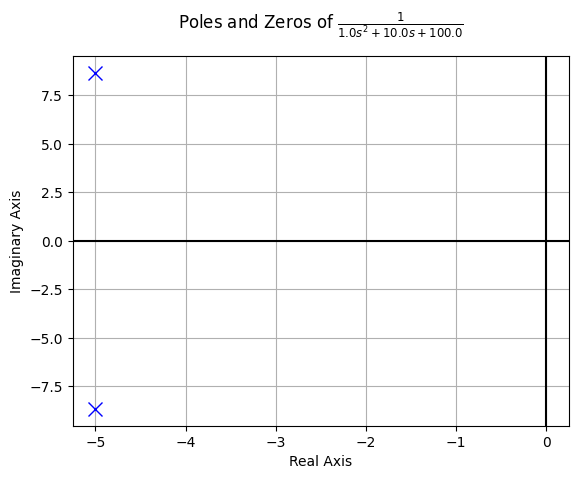

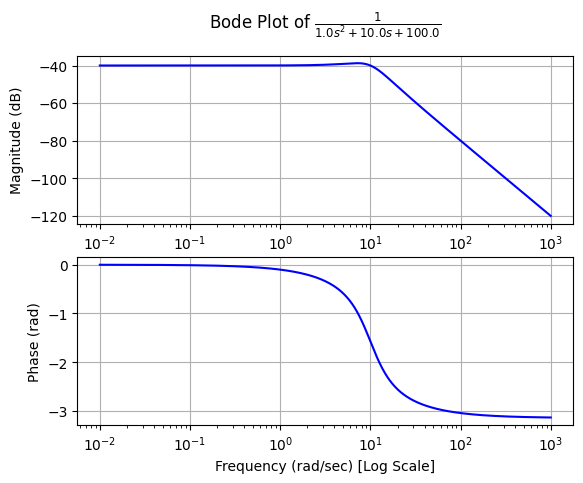

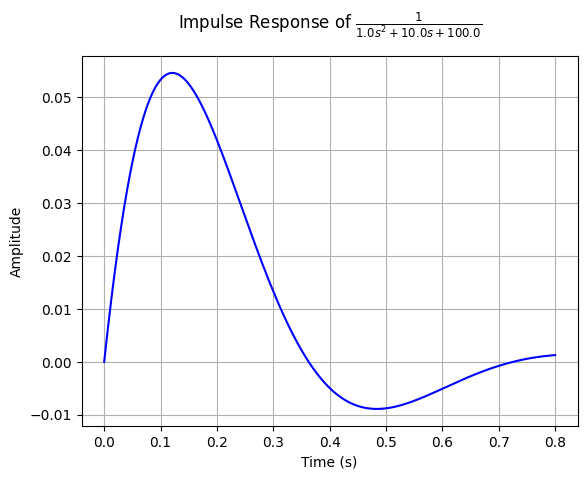

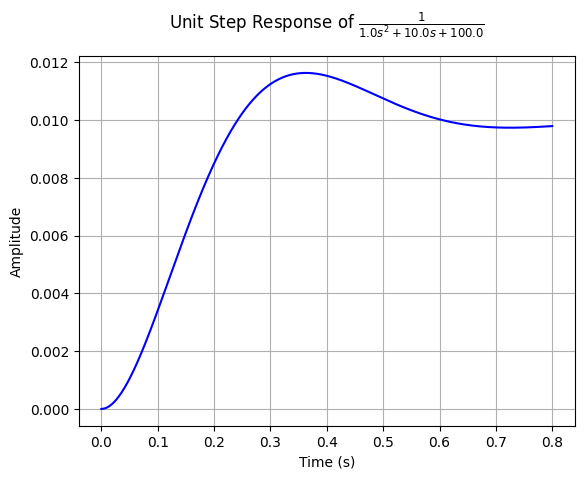

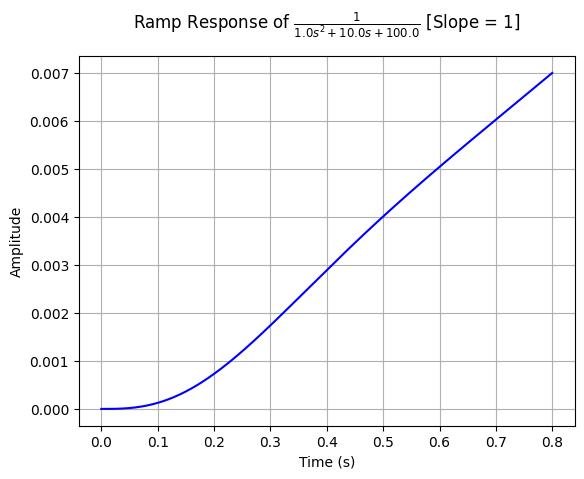

Underdamped – closed-loop (unity feedback)


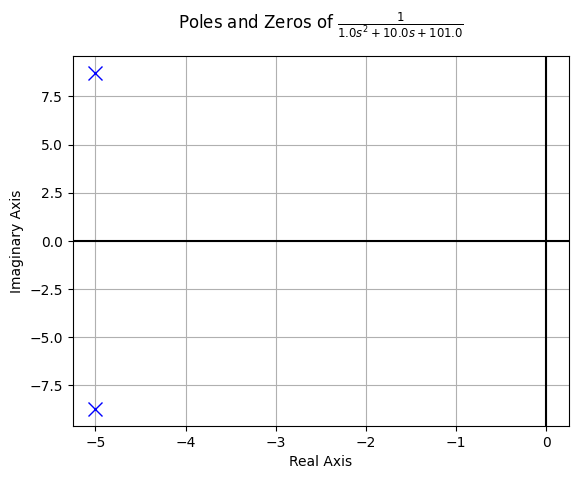

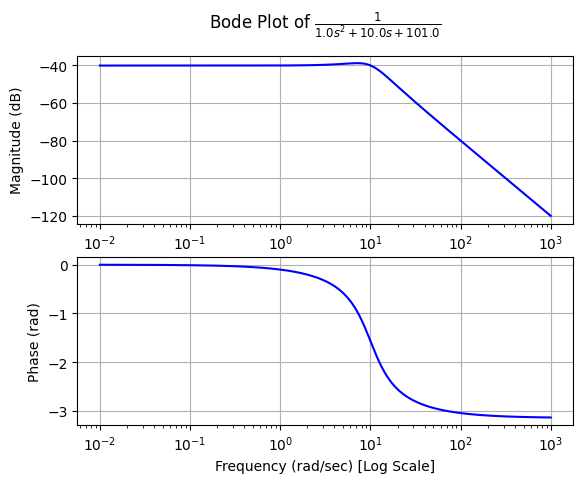

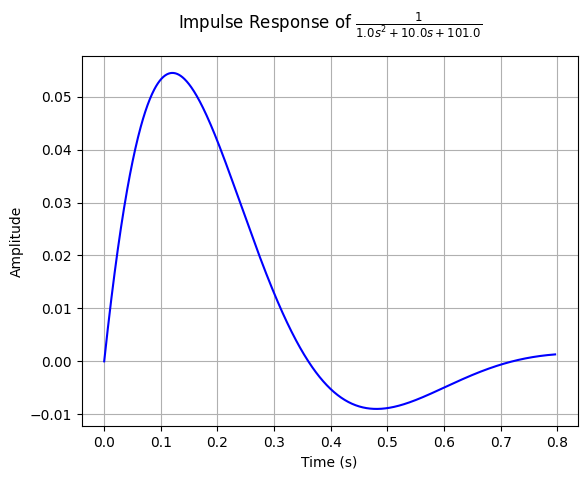

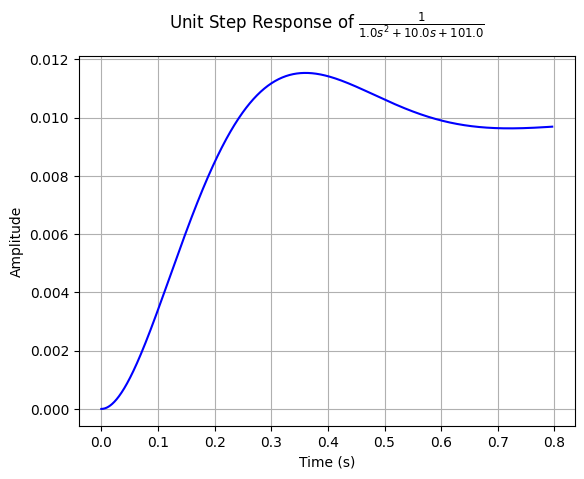

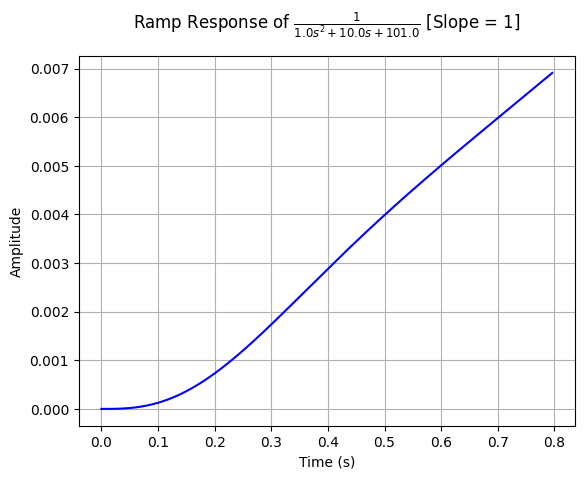

Critically damped – open-loop


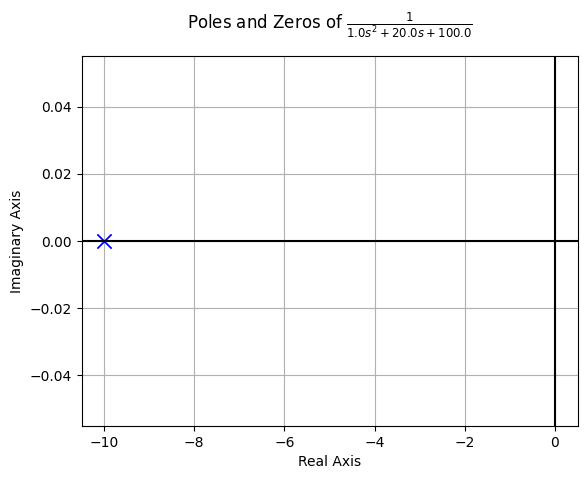

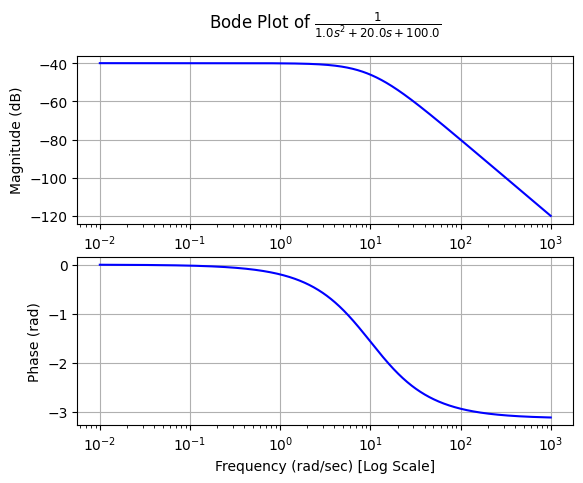

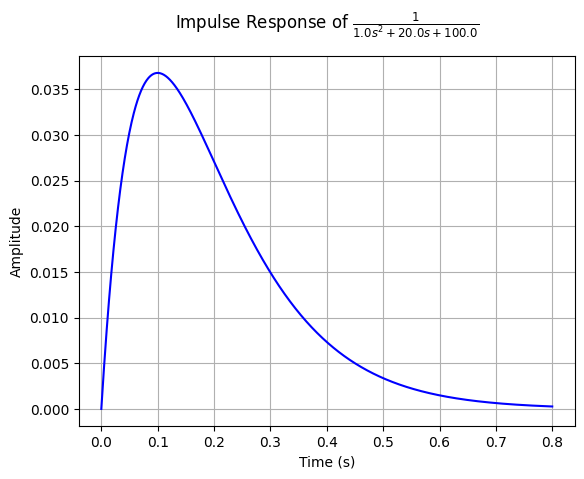

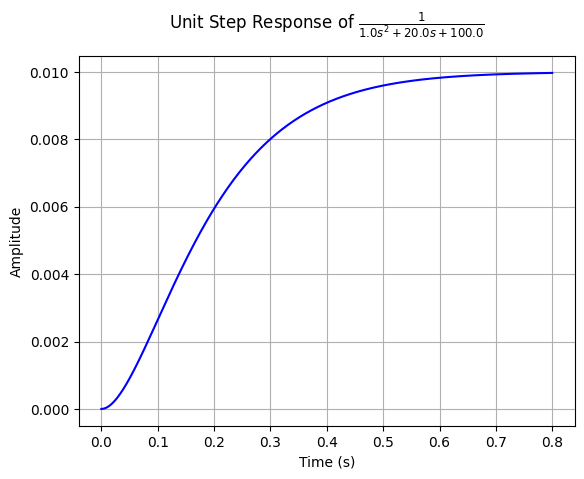

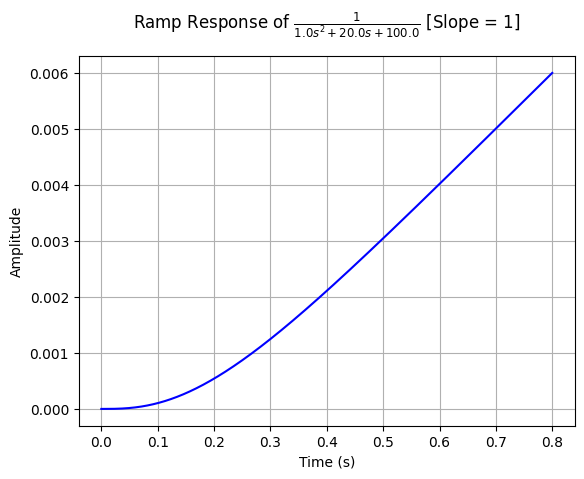

Critically damped – closed-loop (unity feedback)


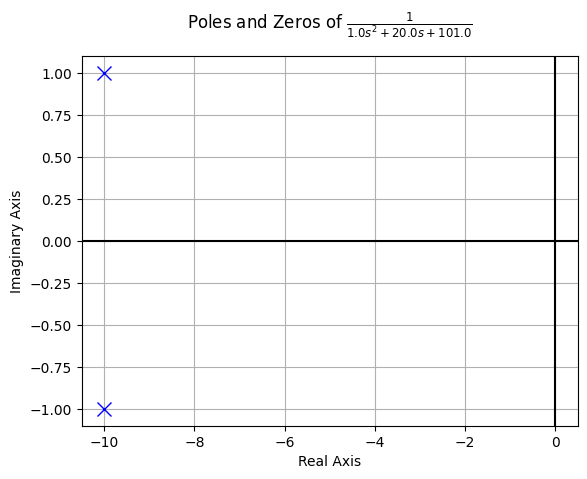

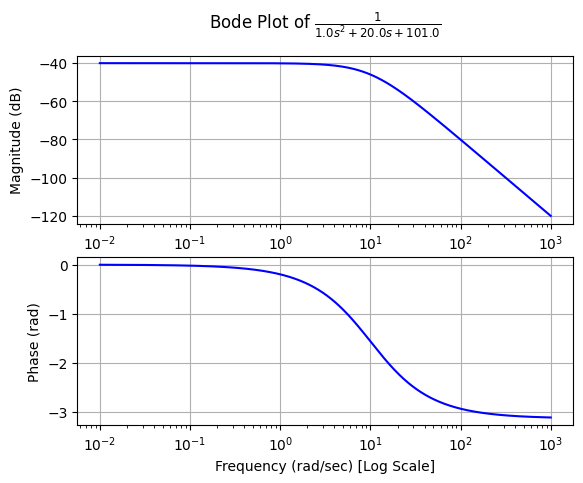

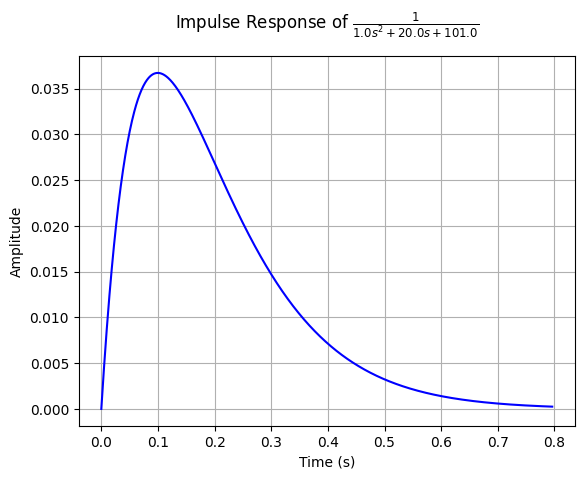

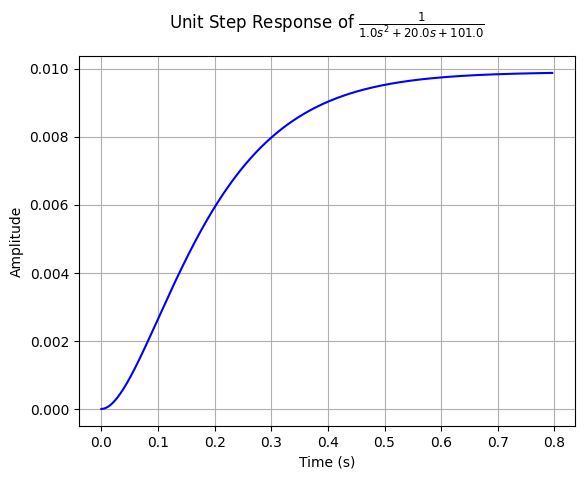

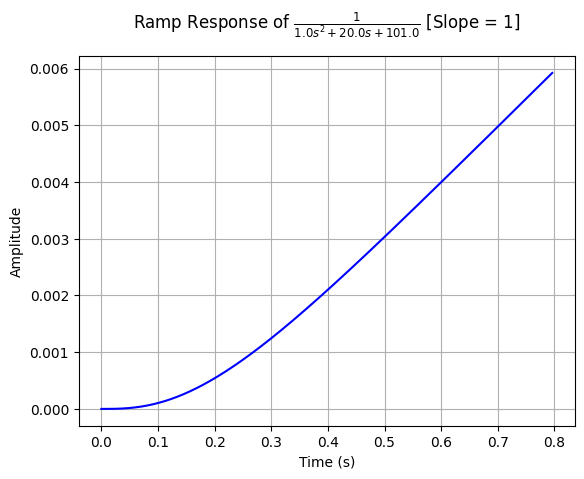

Overdamped – open-loop


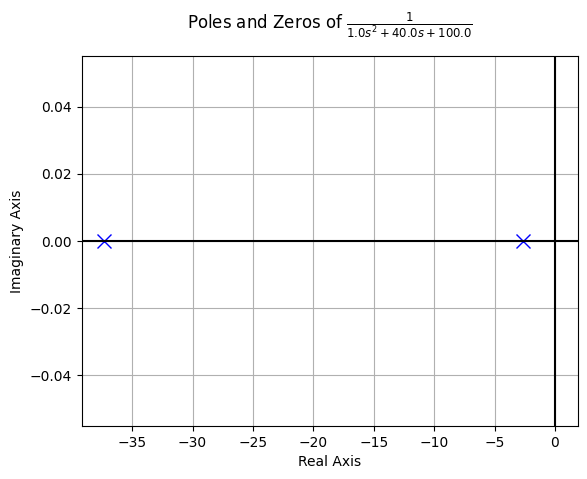

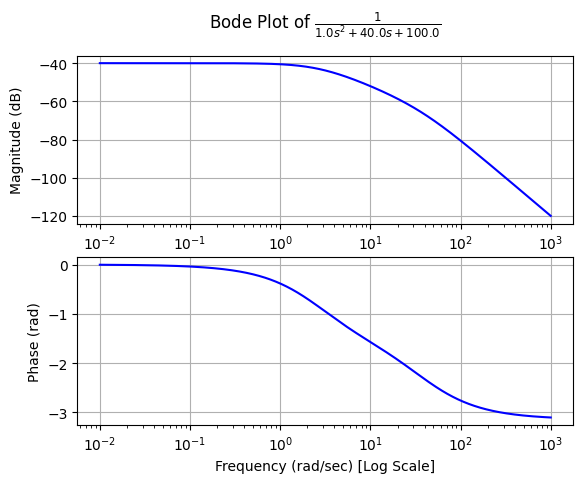

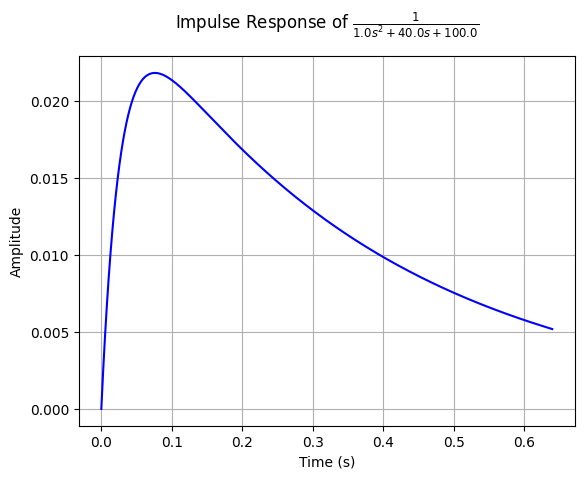

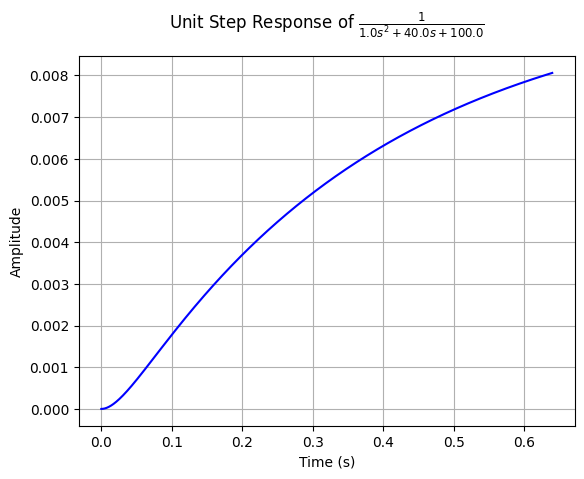

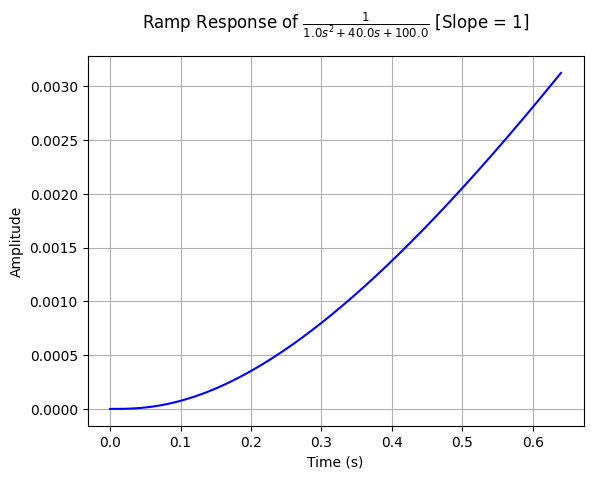

Overdamped – closed-loop (unity feedback)


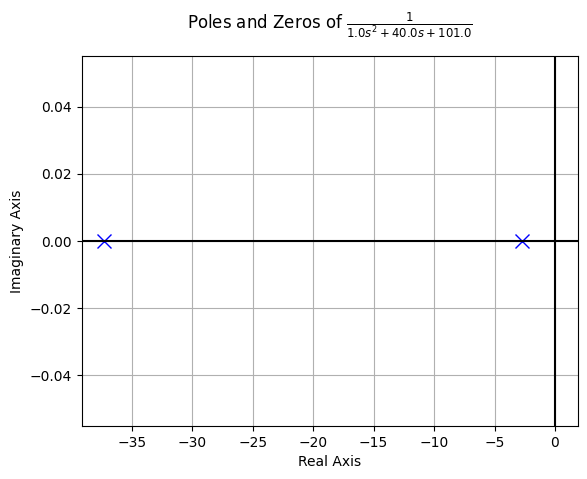

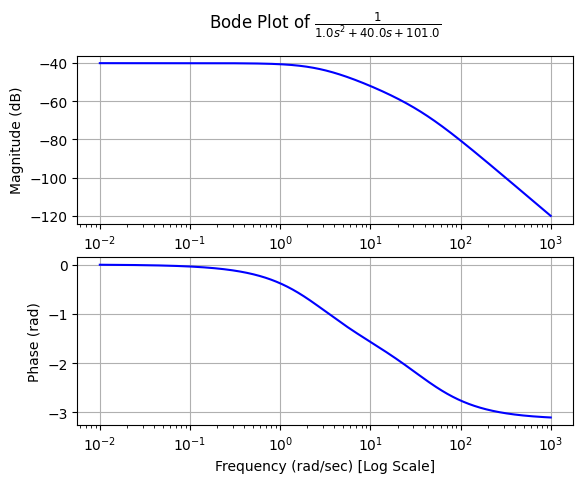

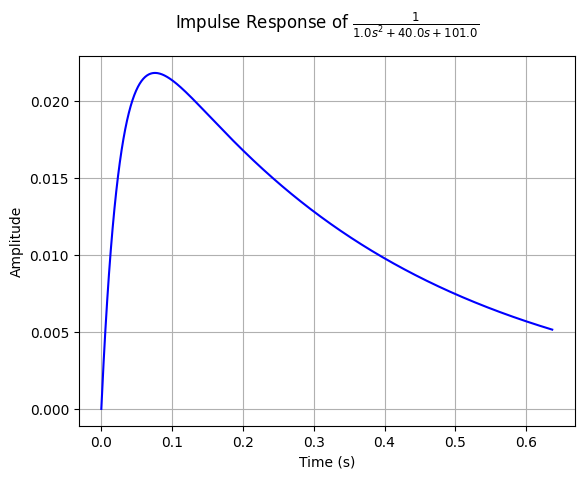

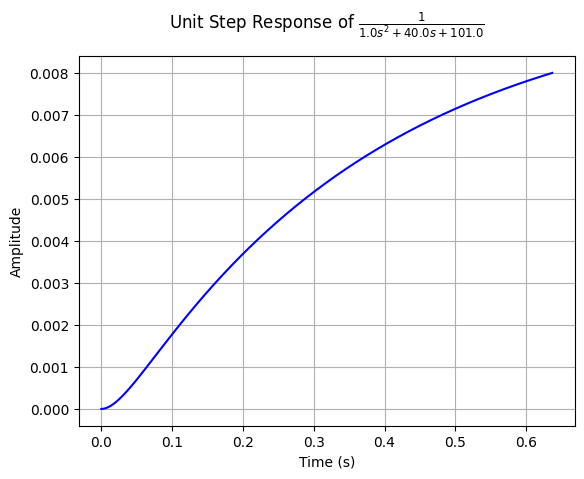

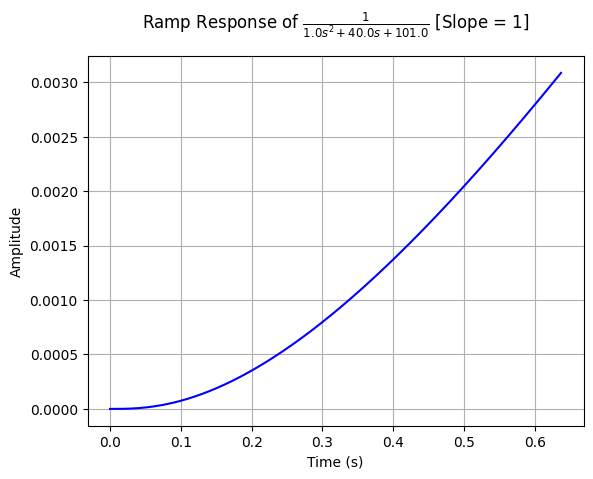

In [13]:
for label, params in cases.items():
    base_tf = mechanical_tf(**params)
    open_tw = plot_windows[(label, "open-loop")]
    print(f"{label} – open-loop")
    ctrl.pole_zero_plot(base_tf, title=f"{label} open-loop pole-zero", show=True)
    ctrl.bode_plot(base_tf, initial_exp=-2, final_exp=3, show=True)
    ctrl.impulse_response_plot(base_tf, upper_limit=open_tw, show=True)
    ctrl.step_response_plot(base_tf, upper_limit=open_tw, show=True)
    ctrl.ramp_response_plot(base_tf, upper_limit=open_tw, show=True)

    closed_tf = closed_loop_unity(base_tf)
    closed_tw = plot_windows[(label, "closed-loop")]
    print(f"{label} – closed-loop (unity feedback)")
    ctrl.pole_zero_plot(closed_tf, title=f"{label} closed-loop pole-zero", show=True)
    ctrl.bode_plot(closed_tf, initial_exp=-2, final_exp=3, show=True)
    ctrl.impulse_response_plot(closed_tf, upper_limit=closed_tw, show=True)
    ctrl.step_response_plot(closed_tf, upper_limit=closed_tw, show=True)
    ctrl.ramp_response_plot(closed_tf, upper_limit=closed_tw, show=True)
